In [20]:
import os
import math
import itertools
from glob import glob
from abc import ABC, abstractmethod
from typing import Optional, Any, Tuple

import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, RMSprop, Optimizer
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import (
    Compose, 
    ToTensor, 
    Normalize, 
    RandomHorizontalFlip, 
    RandomRotation
)

import pytorch_lightning as L
from pytorch_lightning.loggers import CSVLogger

from sklearn.model_selection import train_test_split

## –ó–∞–¥–∞—á–∞

- [x] –ù–∞–π—Ç–∏ –¥–∞–Ω–Ω—ã–µ –≤ –≤–∏–¥–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –¥–ª—è –∑–∞–¥–∞—á–∏ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏. –ù–∞–ø—Ä–∏–º–µ—Ä, –º–æ–∂–Ω–æ –≤–∑—è—Ç—å –¥–∞–Ω–Ω—ã–µ [–æ—Ç—Å—é–¥–∞](http://ufldl.stanford.edu/housenumbers/).
- [x] –†–µ–∞–ª–∏–∑–æ–≤–∞—Ç—å –∫–ª–∞—Å—Å—ã, –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã–µ –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è —Å–µ—Ç–∏ —Å–æ —Å–ª–µ–¥—É—é—â–∏–º–∏ —Å–ª–æ—è–º–∏
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [x] –ò—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å CrossEntropyLoss –∏ L2-—Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—é.
- [x] –û–±—É—á–∏—Ç—å –º–æ–¥–µ–ª—å –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö, –ø–æ–¥–±–∏—Ä–∞—Ç—å –ø–∞—Ä–∞–º–µ—Ç—Ä—ã (–æ—Å–æ–±–µ–Ω–Ω–æ learning rate) –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –∏ –æ—Ü–µ–Ω–∏—Ç—å –∫–∞—á–µ—Å—Ç–≤–æ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π. –ê–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞—Ç—å –≥—Ä–∞—Ñ–∏–∫–∏ train/val loss, –ø—Ä–æ–≤–µ—Ä—è—Ç—å –Ω–∞ –∫–∞–∂–¥–æ–º —à–∞–≥–µ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ—Å—Ç—å –≤—ã—á–∏—Å–ª–µ–Ω–∏—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤ —Å –ø–æ–º–æ—â—å—é —Ä–∞–∑–Ω–æ—Å—Ç–Ω–æ–π –æ—Ü–µ–Ω–∫–∏.
- [x] * (**+2 –±–∞–ª–ª–∞**) –î–æ–±–∞–≤–∏—Ç—å Batch normalization.
- [x] * (**+2 –±–∞–ª–ª–∞**) –í –∫–∞—á–µ—Å—Ç–≤–µ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –æ–¥–∏–Ω –∏–∑: Momentum, RMSprop.
- [x] * (**+1 –±–∞–ª–ª**) –¢–∞–∫–∂–µ —Ä–µ–∞–ª–∏–∑–æ–≤–∞—Ç—å –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä Adam.

In [21]:
# DATASET CONSTANTS
DATASET_PATH = "./data"
RANDOM_SEED = 777
WORKERS = 12
BATCH_SIZE = 64
VAL_SIZE = 0.2

# –î–∞—Ç–∞—Å–µ—Ç FashionMNIST

## –û–±—â–∞—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è

FashionMNIST ‚Äî —Å–æ–≤—Ä–µ–º–µ–Ω–Ω–∞—è –∞–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–∞ –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–æ–º—É MNIST, –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è—é—â–∞—è —Å–æ–±–æ–π –∫–æ–ª–ª–µ–∫—Ü–∏—é –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –ø—Ä–µ–¥–º–µ—Ç–æ–≤ –æ–¥–µ–∂–¥—ã –∏ –∞–∫—Å–µ—Å—Å—É–∞—Ä–æ–≤. –≠—Ç–æ—Ç –¥–∞—Ç–∞—Å–µ—Ç —Å–ø–µ—Ü–∏–∞–ª—å–Ω–æ —Ä–∞–∑—Ä–∞–±–æ—Ç–∞–Ω –¥–ª—è –∑–∞–¥–∞—á –∫–æ–º–ø—å—é—Ç–µ—Ä–Ω–æ–≥–æ –∑—Ä–µ–Ω–∏—è –∏ –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è, —Å–æ—Ö—Ä–∞–Ω—è—è –ø—Ä–æ—Å—Ç–æ—Ç—É –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–≥–æ MNIST, –Ω–æ –ø—Ä–µ–¥–ª–∞–≥–∞—è –±–æ–ª–µ–µ —Å–ª–æ–∂–Ω—É—é –∏ —Ä–µ–∞–ª–∏—Å—Ç–∏—á–Ω—É—é –∑–∞–¥–∞—á—É –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏.

## –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏

- **–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞:** 70 000 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
  - **–û–±—É—á–∞—é—â–∞—è –≤—ã–±–æ—Ä–∫–∞:** 60 000 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
  - **–¢–µ—Å—Ç–æ–≤–∞—è –≤—ã–±–æ—Ä–∫–∞:** 10 000 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
- **–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π:** 28√ó28 –ø–∏–∫—Å–µ–ª–µ–π (–æ–¥–Ω–æ–∫–∞–Ω–∞–ª—å–Ω—ã–µ, –≥—Ä–∞–¥–∞—Ü–∏–∏ —Å–µ—Ä–æ–≥–æ)
- **–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö:** 8-–±–∏—Ç–Ω—ã–µ —Ü–µ–ª—ã–µ —á–∏—Å–ª–∞ (0-255)
- **–§–æ—Ä–º–∞—Ç —Ö—Ä–∞–Ω–µ–Ω–∏—è:** –¢–µ–Ω–∑–æ—Ä—ã PyTorch —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏ [N, 1, 28, 28]

## –ö–ª–∞—Å—Å—ã (10 –∫–∞—Ç–µ–≥–æ—Ä–∏–π)

| –ò–Ω–¥–µ–∫—Å | –ö–ª–∞—Å—Å | –û–ø–∏—Å–∞–Ω–∏–µ |
|--------|-------|----------|
| 0 | T-shirt/top | –§—É—Ç–±–æ–ª–∫–∞/—Ç–æ–ø |
| 1 | Trouser | –ë—Ä—é–∫–∏ |
| 2 | Pullover | –°–≤–∏—Ç–µ—Ä |
| 3 | Dress | –ü–ª–∞—Ç—å–µ |
| 4 | Coat | –ü–∞–ª—å—Ç–æ |
| 5 | Sandal | –°–∞–Ω–¥–∞–ª–∏–∏ |
| 6 | Shirt | –†—É–±–∞—à–∫–∞ |
| 7 | Sneaker | –ö—Ä–æ—Å—Å–æ–≤–∫–∏ |
| 8 | Bag | –°—É–º–∫–∞ |
| 9 | Ankle boot | –ë–æ—Ç–∏–Ω–∫–∏ |

Train: 48000, Val: 12000, Test: 10000


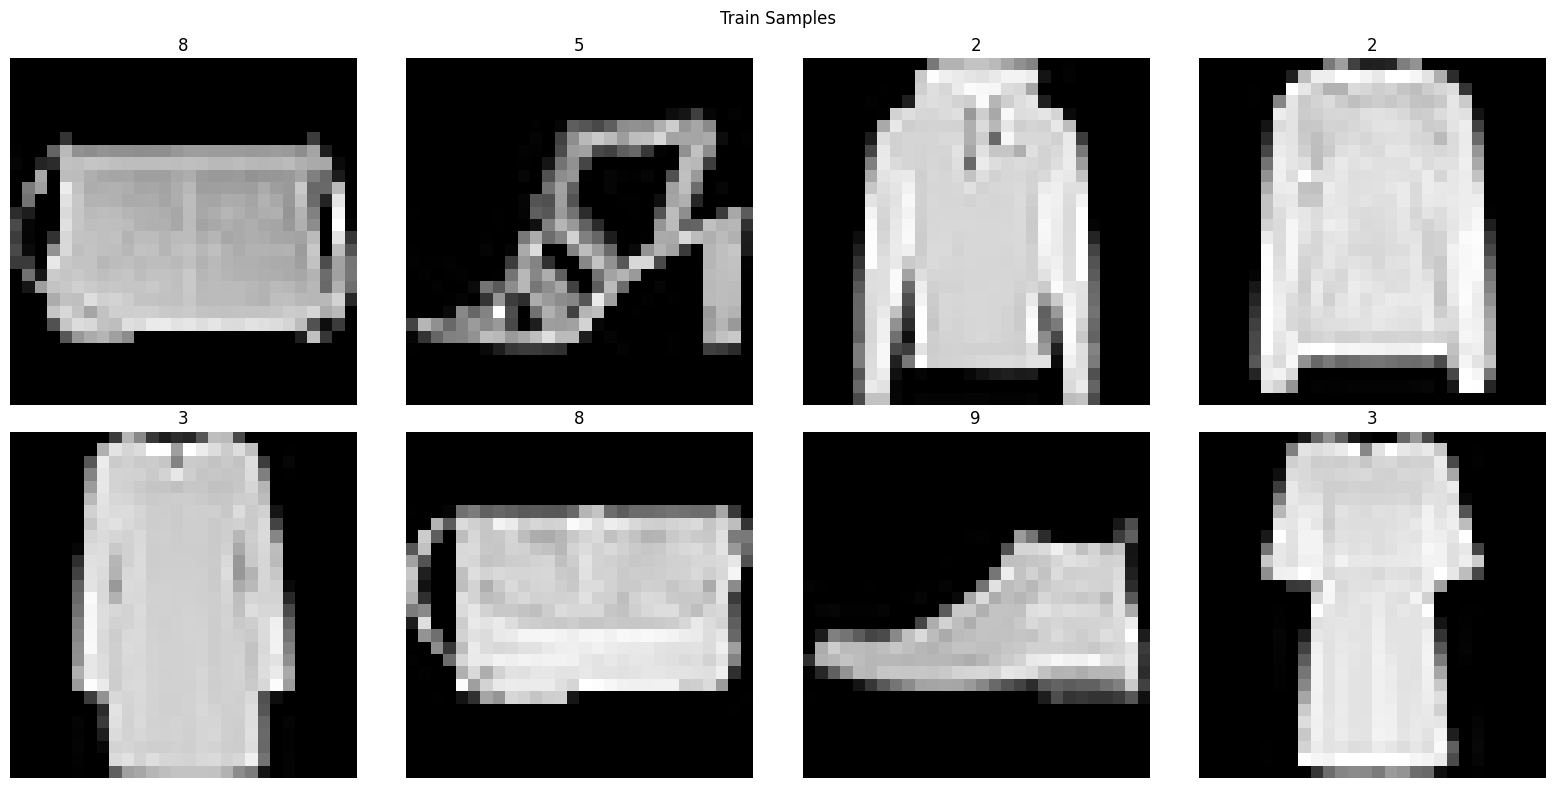

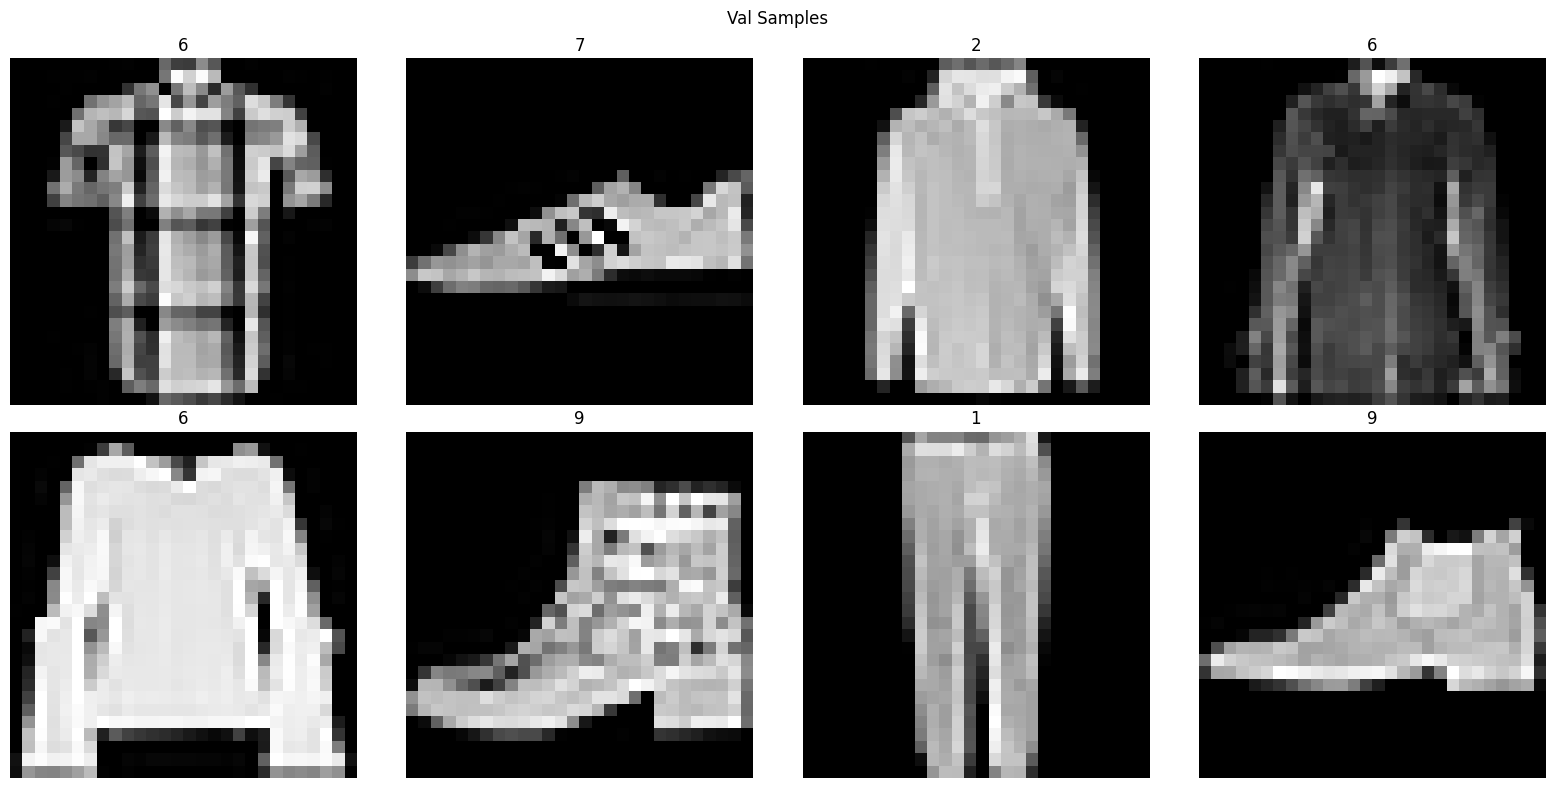

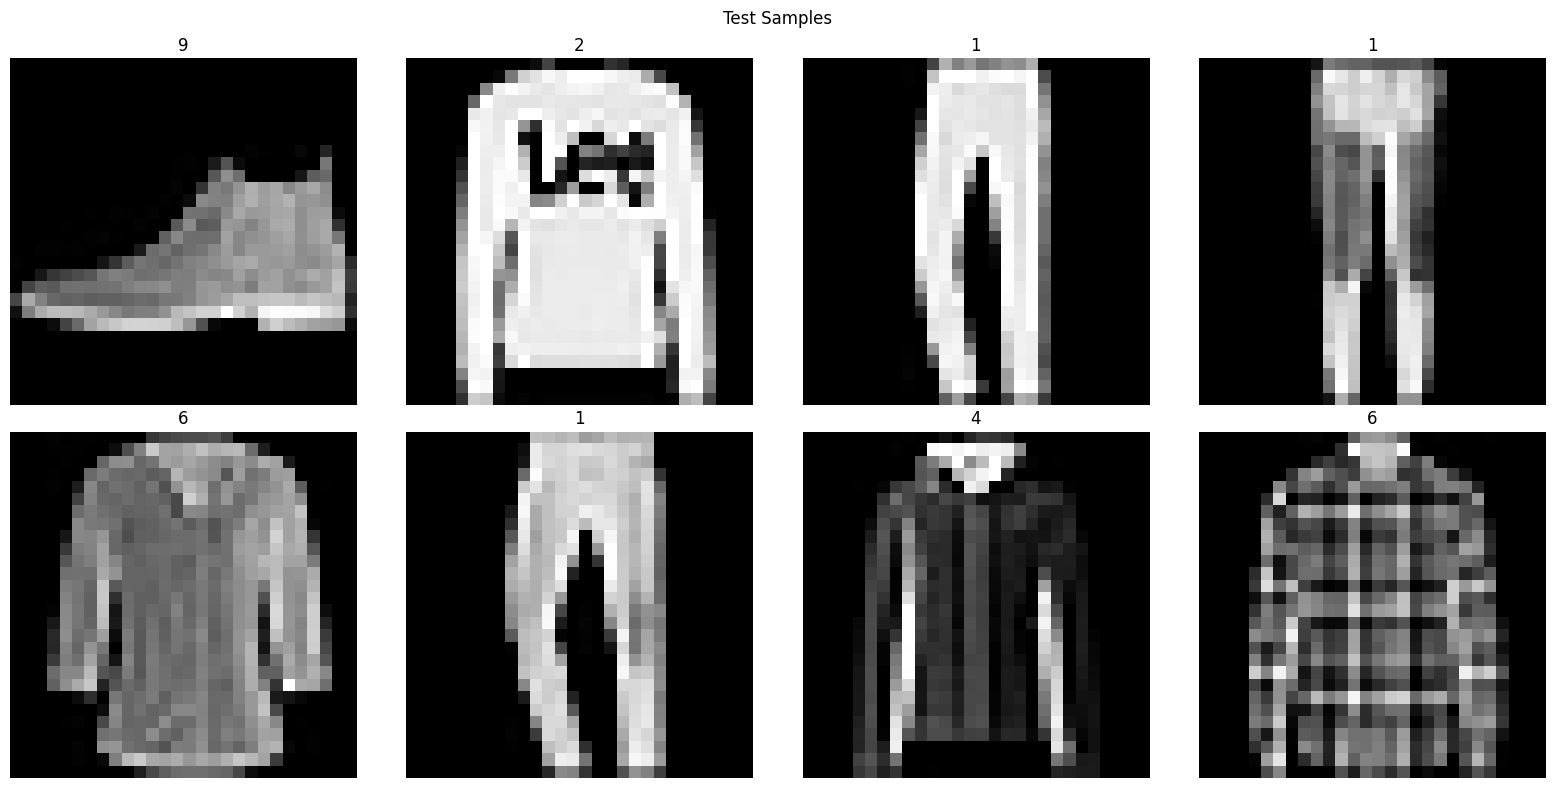

In [22]:
def get_transforms(augment=True):
    transforms = [ToTensor(), Normalize((0.2860,), (0.3530,))]
    if augment:
        transforms.insert(0, RandomHorizontalFlip(p=0.5))
        transforms.insert(0, RandomRotation(10))
    return Compose(transforms)

def show_samples(loader, title):
    images, labels = next(iter(loader))
    _, axes = plt.subplots(2, 4, figsize=(16, 8))
    for ax, img, label in zip(axes.ravel(), images[:18], labels[:18]):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(label.item())
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

full_training_set = FashionMNIST(
    root=DATASET_PATH,
    download=True,
    train=True,
    transform=get_transforms(augment=True))
testing_set = FashionMNIST(
    root=DATASET_PATH,
    download=True,
    train=False,
    transform=get_transforms(augment=False))

train_indices, val_indices = train_test_split(
    range(len(full_training_set)),
    test_size=VAL_SIZE,
    random_state=RANDOM_SEED,
    shuffle=True,
    stratify=full_training_set.targets.numpy())

training_set = Subset(full_training_set, train_indices)
validation_set = Subset(full_training_set, val_indices)
validation_set.dataset.transform = get_transforms(augment=False)

train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
test_loader = DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

print(f"Train: {len(training_set)}, Val: {len(validation_set)}, Test: {len(testing_set)}")
show_samples(train_loader, "Train Samples")
show_samples(val_loader, "Val Samples")
show_samples(test_loader, "Test Samples")

# Adam (Adaptive Moment Estimation)

**Adam** ‚Äî –ø–µ—Ä–µ–¥–æ–≤–æ–π —Å—Ç–æ—Ö–∞—Å—Ç–∏—á–µ—Å–∫–∏–π –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä, –æ–±—ä–µ–¥–∏–Ω—è—é—â–∏–π –ø—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞ –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ RMSProp –∏ Momentum –¥–ª—è —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è –Ω–µ–π—Ä–æ–Ω–Ω—ã—Ö —Å–µ—Ç–µ–π.

## –ü—Ä–∏–Ω—Ü–∏–ø —Ä–∞–±–æ—Ç—ã
–ê–ª–≥–æ—Ä–∏—Ç–º –≤—ã—á–∏—Å–ª—è–µ—Ç –∏–Ω–¥–∏–≤–∏–¥—É–∞–ª—å–Ω—ã–µ –∞–¥–∞–ø—Ç–∏–≤–Ω—ã–µ —Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞, –∏—Å–ø–æ–ª—å–∑—É—è:
- **–ü–µ—Ä–≤—ã–π –º–æ–º–µ–Ω—Ç** (—ç–∫—Å–ø–æ–Ω–µ–Ω—Ü–∏–∞–ª—å–Ω–æ–µ —Å–∫–æ–ª—å–∑—è—â–µ–µ —Å—Ä–µ–¥–Ω–µ–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤)
- **–í—Ç–æ—Ä–æ–π –º–æ–º–µ–Ω—Ç** (—ç–∫—Å–ø–æ–Ω–µ–Ω—Ü–∏–∞–ª—å–Ω–æ–µ —Å–∫–æ–ª—å–∑—è—â–µ–µ —Å—Ä–µ–¥–Ω–µ–µ –∫–≤–∞–¥—Ä–∞—Ç–æ–≤ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤)

## –ö–ª—é—á–µ–≤—ã–µ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏
- –ê–¥–∞–ø—Ç–∏–≤–Ω–∞—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞
- –ö–æ—Ä—Ä–µ–∫—Ü–∏—è —Å–º–µ—â–µ–Ω–∏—è —ç–∫—Å–ø–æ–Ω–µ–Ω—Ü–∏–∞–ª—å–Ω—ã—Ö —Å–∫–æ–ª—å–∑—è—â–∏—Ö —Å—Ä–µ–¥–Ω–∏—Ö
- –£—Å—Ç–æ–π—á–∏–≤–æ—Å—Ç—å –∫ –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏—é –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤
- –≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –¥–ª—è –∑–∞–¥–∞—á —Å —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω—ã–º–∏ –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞–º–∏
- –í—Å—Ç—Ä–æ–µ–Ω–Ω–∞—è L2-—Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è (weight decay)
- –ú–æ–¥–∏—Ñ–∏–∫–∞—Ü–∏—è AMSGrad –¥–ª—è —É–ª—É—á—à–µ–Ω–∏—è —Å—Ö–æ–¥–∏–º–æ—Å—Ç–∏

## –ì–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã
| –ü–∞—Ä–∞–º–µ—Ç—Ä      | –û–ø–∏—Å–∞–Ω–∏–µ                                      | –¢–∏–ø–∏—á–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ  |
|---------------|-----------------------------------------------|--------------------|
| `lr`          | –ë–∞–∑–æ–≤–∞—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è                    | 0.001              |
| `betas`       | –ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã –∑–∞—Ç—É—Ö–∞–Ω–∏—è –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –º–æ–º–µ–Ω—Ç–æ–≤   | (0.9, 0.999)       |
| `eps`         | –ú–∞–ª–∞—è –∫–æ–Ω—Å—Ç–∞–Ω—Ç–∞ –¥–ª—è —á–∏—Å–ª–µ–Ω–Ω–æ–π —Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç–∏   | 1e-8               |
| `weight_decay`| –ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç L2-—Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏                 | 0 - 0.01           |
| `amsgrad`     | –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –º–æ–¥–∏—Ñ–∏–∫–∞—Ü–∏–∏ AMSGrad            | False/True         |

In [23]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, 
                 weight_decay=0, amsgrad=False):
        defaults = dict(lr=lr, betas=betas, eps=eps, 
                       weight_decay=weight_decay, amsgrad=amsgrad)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]
                
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    if group['amsgrad']:
                        state['max_exp_avg_sq'] = torch.zeros_like(p)

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                state['step'] += 1
                beta1, beta2 = group['betas']

                state['exp_avg'].mul_(beta1).add_(grad, alpha=1-beta1)
                state['exp_avg_sq'].mul_(beta2).addcmul_(grad, grad, value=1-beta2)

                bias_corr1 = 1 - beta1 ** state['step']
                bias_corr2 = 1 - beta2 ** state['step']
                
                denom = (state['exp_avg_sq'].sqrt() / math.sqrt(bias_corr2)).add_(group['eps'])
                
                if group['amsgrad']:
                    torch.maximum(state['max_exp_avg_sq'], state['exp_avg_sq'], out=state['max_exp_avg_sq'])
                    denom = (state['max_exp_avg_sq'].sqrt() / math.sqrt(bias_corr2)).add_(group['eps'])

                step_size = group['lr'] / bias_corr1
                p.addcdiv_(state['exp_avg'], denom, value=-step_size)

        return loss

In [24]:
class ILayer(nn.Module, ABC):
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def backward(self, grad_output):
        pass

# –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ –Ω–µ–π—Ä–æ–Ω–Ω–æ–π —Å–µ—Ç–∏: —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—è –∫–ª—é—á–µ–≤—ã—Ö –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–æ–≤

## –ö–æ–º–ø–æ–Ω–µ–Ω—Ç—ã –Ω–µ–π—Ä–æ–Ω–Ω–æ–π —Å–µ—Ç–∏
–í –Ω–∞—à–µ–π —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω—ã –¥–≤–∞ –æ—Å–Ω–æ–≤–Ω—ã—Ö —Ç–∏–ø–∞ —Å–ª–æ—ë–≤, –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã—Ö –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è –º–Ω–æ–≥–æ—Å–ª–æ–π–Ω–æ–≥–æ –ø–µ—Ä—Ü–µ–ø—Ç—Ä–æ–Ω–∞:

| –¢–∏–ø —Å–ª–æ—è                | –ö–ª–∞—Å—Å            | –ù–∞–∑–Ω–∞—á–µ–Ω–∏–µ                                                                 |
|-------------------------|------------------|---------------------------------------------------------------------------|
| –õ–∏–Ω–µ–π–Ω–æ–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ | `FullyConnected` | –í—ã–ø–æ–ª–Ω—è–µ—Ç –ª–∏–Ω–µ–π–Ω–æ–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö: $y = xW + b$            |
| –ù–µ–ª–∏–Ω–µ–π–Ω–∞—è –∞–∫—Ç–∏–≤–∞—Ü–∏—è    | `Relu`           | –ü—Ä–∏–º–µ–Ω—è–µ—Ç –ø–æ—ç–ª–µ–º–µ–Ω—Ç–Ω—É—é —Ñ—É–Ω–∫—Ü–∏—é –∞–∫—Ç–∏–≤–∞—Ü–∏–∏ $\text{max}(0, x)$     

### –ò–Ω—Ç–µ—Ä—Ñ–µ–π—Å —Å–ª–æ—ë–≤
–ö–∞–∂–¥—ã–π —Å–ª–æ–π —Ä–µ–∞–ª–∏–∑—É–µ—Ç –µ–¥–∏–Ω—ã–π –∏–Ω—Ç–µ—Ä—Ñ–µ–π—Å ILayer –∏ –ø–æ–¥–¥–µ—Ä–∂–∏–≤–∞–µ—Ç —Å–ª–µ–¥—É—é—â–∏–µ –æ–ø–µ—Ä–∞—Ü–∏–∏:

In [ ]:
def forward(self, x: torch.Tensor) -> torch.Tensor:
    # –ü—Ä—è–º–æ–µ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–∏–µ: –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
    ...

def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
    # –û–±—Ä–∞—Ç–Ω–æ–µ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–∏–µ: –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤
    ...

### –õ–∏–Ω–µ–π–Ω—ã–π —Å–ª–æ–π (FullyConnected)

In [ ]:
class FullyConnected(ILayer):
    weight: nn.Parameter
    bias: nn.Parameter
    input: Optional[Any]

    def __init__(self, in_features: int, out_features: int, dtype=torch.float32):
        super().__init__()
        self.weight = nn.Parameter(torch.empty((in_features, out_features), dtype=dtype))
        self.bias = nn.Parameter(torch.empty(out_features, dtype=dtype))
        self.input = None
        self.reset_parameters()
    
    def reset_parameters(self) -> None:
        nn.init.kaiming_normal_(self.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.bias, 0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.input = x
        return x @ self.weight + self.bias
    
    def backward(self, grad_output: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        assert self.input is not None

        grad_input = grad_output @ self.weight.T
        grad_weight = self.input.T @ grad_output
        grad_bias = grad_output.sum(dim=0)
        return grad_input, grad_weight, grad_bias

# –°–ª–æ–π –∞–∫—Ç–∏–≤–∞—Ü–∏–∏ (ReLU)

In [25]:
class Relu(ILayer):
    mask: Optional[Any]

    def __init__(self):
        super().__init__()
        self.mask = None
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.mask = x <= 0
        return x.clone().masked_fill_(self.mask, 0)
    
    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:
        assert self.mask is not None
        grad_input = grad_output.clone().masked_fill_(self.mask, 0)
        return grad_input

# –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ –º–æ–¥–µ–ª–∏ –≤ PyTorch Lightning

## –ö–ª–∞—Å—Å `LitModel`
`LitModel` - –∫–æ–º–ø–∞–∫—Ç–Ω–∞—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—è –æ–±—É—á–∞–µ–º–æ–π –Ω–µ–π—Ä–æ–Ω–Ω–æ–π —Å–µ—Ç–∏ –Ω–∞ –±–∞–∑–µ PyTorch Lightning.

## –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞
–ü—Ä–∏–º–µ–Ω—è–µ—Ç—Å—è –≤ `task07.ipynb`

## –ö–ª—é—á–µ–≤—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
| –ü–∞—Ä–∞–º–µ—Ç—Ä        | –ó–Ω–∞—á–µ–Ω–∏–µ   | –û–ø–∏—Å–∞–Ω–∏–µ                          |
|-----------------|------------|-----------------------------------|
| `hidden_size`   | 256        | –†–∞–∑–º–µ—Ä —Å–∫—Ä—ã—Ç–æ–≥–æ —Å–ª–æ—è              |
| `batch_norm`    | False      | –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤            |
| `optimizer_name`| 'adam'     | –¢–∏–ø –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞                  |
| `lr`           | 1e-3       | –°–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è                 |
| `weight_decay`  | 0.005      | L2-—Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è                  |

## –û—Å–Ω–æ–≤–Ω—ã–µ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–∏

### –û–±—É—á–µ–Ω–∏–µ
- **–§—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å**: –ö—Ä–æ—Å—Å-—ç–Ω—Ç—Ä–æ–ø–∏—è
- **–ú–µ—Ç—Ä–∏–∫–∏**: –¢–æ—á–Ω–æ—Å—Ç—å –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏

### –°–∏—Å—Ç–µ–º–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤
- –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –∞–Ω–∞–ª–∏—Ç–∏—á–µ—Å–∫–∏—Ö –∏ —á–∏—Å–ª–µ–Ω–Ω—ã—Ö –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤
- –ü—Ä–æ–≤–µ—Ä–∫–∞ –∫–∞–∂–¥—ã–µ 100 –±–∞—Ç—á–µ–π
- –ü–æ—Ä–æ–≥ –ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏—è: `1e-3`

### –û–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä—ã
- SGD (—Å –º–æ–º–µ–Ω—Ç–æ–º `0.9`)
- Adam (–∞–¥–∞–ø—Ç–∏–≤–Ω—ã–π)
- RMSprop (`Œ±=0.99`)

## –ü—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞
- –ú–æ–¥—É–ª—å–Ω–æ—Å—Ç—å –∏ –ø—Ä–æ—Å—Ç–æ—Ç–∞ –º–æ–¥–∏—Ñ–∏–∫–∞—Ü–∏–∏
- –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–µ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏–µ –º–µ—Ç—Ä–∏–∫
- –ù–∞–¥–µ–∂–Ω–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ—Å—Ç–∏ –æ–±—Ä–∞—Ç–Ω–æ–≥–æ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–∏—è –æ—à–∏–±–∫–∏

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=256, batch_norm=False, input_size=784, output_size=10):
        super().__init__()
        self.fc1 = FullyConnected(input_size, hidden_size)
        self.relu = Relu()
        self.bn = nn.BatchNorm1d(hidden_size) if batch_norm else nn.Identity()
        self.fc2 = FullyConnected(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        return self.fc2(x)


class LitModel(L.LightningModule):
    _EPS = 1e-4
    _GRAD_CHECK_INTERVAL = 100
    _OPTIMIZERS = {
            'SGD': SGD,
            'Adam': Adam,
            'RMSprop': RMSprop
        }
    _SGD_MOMENTUM = 0.9
    _RMSPROP_ALPHA = 0.99


    def __init__(self, hidden_size=256, batch_norm=False, optimizer_name='adam', lr=1e-3, weight_decay=0.005):
        super().__init__()
        self.save_hyperparameters('optimizer_name', 'lr', 'weight_decay')
        self.model = NeuralNetwork(hidden_size, batch_norm)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        def _validate_gradients(x, y):
            original_params = {n: p.detach().clone() for n, p in self.model.named_parameters()}
            
            for name, param in self.model.named_parameters():
                if param.grad is None:
                    continue
                    
                analytic_grad = param.grad.data.clone()
                numerical_grad = torch.zeros_like(param.data)
                
                for i in range(param.numel()):
                    param.data.view(-1)[i] += self._EPS
                    loss_plus = F.cross_entropy(self.model(x), y).item()
                    
                    param.data.view(-1)[i] -= 2 * self._EPS
                    loss_minus = F.cross_entropy(self.model(x), y).item()
                    
                    param.data.view(-1)[i] += self._EPS
                    
                    numerical_grad.view(-1)[i] = (loss_plus - loss_minus) / (2 * self._EPS)
                
                grad_diff = torch.norm(analytic_grad - numerical_grad) / (
                    torch.norm(analytic_grad) + torch.norm(numerical_grad) + 1e-8)
                
                if grad_diff > 1e-3:
                    print(f"WARNING: Large gradient difference in {name}: {grad_diff.item():.4f}")
            
            for n, p in self.model.named_parameters():
                p.data.copy_(original_params[n])

        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True)

        if batch_idx % self._GRAD_CHECK_INTERVAL == 0:
            _validate_gradients(x, y)
            
        return loss

    @staticmethod
    def _calc_accuracy(model, batch):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = model(x)
        return (y_hat.argmax(dim=1) == y).float().mean()
    
    @staticmethod
    def _calc_loss(model, batch):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = model(x)
        return F.cross_entropy(y_hat, y)

    def validation_step(self, batch):
        self.log(
            'val_acc', 
            self._calc_accuracy(self.model, batch), 
            on_step=False, 
            on_epoch=True,
        )
        self.log(
            'val_loss', 
            self._calc_loss(self.model, batch), 
            on_step=False, 
            on_epoch=True,
        )
    
    def test_step(self, batch):
        self.log(
            'test_acc', 
            self._calc_accuracy(self.model, batch), 
            on_step=False, 
            on_epoch=True
        )
    
    def configure_optimizers(self):
        optimizer = self._OPTIMIZERS[self.hparams.optimizer_name]
        params = {
            'params': self.parameters(),
            'lr': self.hparams.lr,
            'weight_decay': self.hparams.weight_decay
        }
        
        if self.hparams.optimizer_name == 'SGD':
            params['momentum'] = self._SGD_MOMENTUM
        elif self.hparams.optimizer_name == 'RMSprop':
            params['alpha'] = self._RMSPROP_ALPHA
            
        return optimizer(**params)
    

In [27]:
# LEARNING CONSTANTS
HP_FINDING_EPOCHS = 3
LEARNING_EPOCHS = 15
ACCELERATOR = "cpu"
LOGGER_DIR = "logs"

def train_all(name, epochs, hparams):
    for config in hparams:

        train_loader, val_loader, test_loader = (
            DataLoader(prepared_set, 4096, num_workers=WORKERS, shuffle=shaf_opt) for (prepared_set, shaf_opt) in [
                (training_set, True), 
                (validation_set, False), 
                (testing_set, False)
            ]
        )

        optimizer_name, lr, hidden_size, batch_normalization = config
        
        print(f"\nTraining with: {optimizer_name}, lr={lr:.0e}, hidden_size={hidden_size}, batch_norm={batch_normalization}")

        model = LitModel(
            hidden_size=hidden_size,
            batch_norm=batch_normalization,
            optimizer_name=optimizer_name,
            lr=lr,
        )

        logger = CSVLogger(LOGGER_DIR, name=name)

        logger.log_hyperparams({
            "max_epochs": epochs,
            "lr": lr,
            "optimizer": optimizer_name,
            "hidden_size": hidden_size,
            "batch_normalization": batch_normalization,
        })
        
        trainer = L.Trainer(
            max_epochs=epochs,
            accelerator=ACCELERATOR,
            logger=logger,
            log_every_n_steps=5,
            enable_model_summary=False,
            enable_progress_bar=False,
        )
        
        trainer.validate(model, dataloaders=val_loader, verbose=True)
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
        trainer.test(model, dataloaders=test_loader)

# –°—Ç—Ä–∞—Ç–µ–≥–∏—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤

## –°–∏—Å—Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–π –ø–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏
–° –ø–æ–º–æ—â—å—é –∫–ª–∞—Å—Å–∞ `HyperparameterGrid` –º—ã —Å–æ–∑–¥–∞–µ–º –∏ –∏—Å—Å–ª–µ–¥—É–µ–º –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–æ –≤–æ–∑–º–æ–∂–Ω—ã—Ö –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–π –º–æ–¥–µ–ª–∏ –¥–ª—è –ø–æ–∏—Å–∫–∞ –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ –±–∞–ª–∞–Ω—Å–∞ –º–µ–∂–¥—É —Ç–æ—á–Ω–æ—Å—Ç—å—é –∏ –≤—ã—á–∏—Å–ª–∏—Ç–µ–ª—å–Ω–æ–π —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å—é.

### –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –ø–æ–∏—Å–∫–∞
| –ö–∞—Ç–µ–≥–æ—Ä–∏—è      | –ò—Å—Å–ª–µ–¥—É–µ–º—ã–µ –≤–∞—Ä–∏–∞–Ω—Ç—ã       | –ó–Ω–∞—á–µ–Ω–∏—è                     |
|----------------|---------------------------|-----------------------------|
| –û–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä    | 3 —Ç–∏–ø–∞                    | `Adam`, `RMSprop`, `SGD`    |
| –°–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è | 2 –∑–Ω–∞—á–µ–Ω–∏—è             | `0.01`, `0.001`             |
| –°–∫—Ä—ã—Ç—ã–π —Å–ª–æ–π   | 2 —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏             | `100`, `1000` –Ω–µ–π—Ä–æ–Ω–æ–≤      |
| –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è   | 2 –≤–∞—Ä–∏–∞–Ω—Ç–∞                | –° `BatchNorm`, –±–µ–∑ `BatchNorm` |

**–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–π**: 3 √ó 2 √ó 2 √ó 2 = 24 –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏

## –î–≤—É—Ö—ç—Ç–∞–ø–Ω—ã–π –ø—Ä–æ—Ü–µ—Å—Å –æ—Ç–±–æ—Ä–∞

### 1. –ü—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑
- –ë—ã—Å—Ç—Ä–æ–µ –æ–±—É—á–µ–Ω–∏–µ –≤—Å–µ—Ö –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–π (3 —ç–ø–æ—Ö–∏)
- –†–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏–µ –ø–æ —Ç–æ—á–Ω–æ—Å—Ç–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ
- –û—Ç–±–æ—Ä 3-5 –Ω–∞–∏–±–æ–ª–µ–µ –ø–µ—Ä—Å–ø–µ–∫—Ç–∏–≤–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π

### 2. –ü–æ–ª–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ
- –†–∞—Å—à–∏—Ä–µ–Ω–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ –ª—É—á—à–∏—Ö –∫–∞–Ω–¥–∏–¥–∞—Ç–æ–≤ (15 —ç–ø–æ—Ö)
- –ú–æ–Ω–∏—Ç–æ—Ä–∏–Ω–≥ –∫—Ä–∏–≤—ã—Ö –æ–±—É—á–µ–Ω–∏—è –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è
- –§–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ

## –õ–æ–≥–∏—Ä–æ–≤–∞–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
–î–ª—è –∫–∞–∂–¥–æ–π –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ —Å–æ—Ö—Ä–∞–Ω—è—é—Ç—Å—è:
- –ö—Ä–∏–≤—ã–µ –æ–±—É—á–µ–Ω–∏—è (`loss`, `accuracy`)
- –í—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è
- –§–∏–Ω–∞–ª—å–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –∏ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∞—Ö

## –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è
- –ì—Ä–∞—Ñ–∏–∫–∏ —Å—Ä–∞–≤–Ω–µ–Ω–∏—è —Ç–æ—á–Ω–æ—Å—Ç–∏ –º–µ–∂–¥—É –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è–º–∏
- –¢–µ–ø–ª–æ–≤—ã–µ –∫–∞—Ä—Ç—ã –º–µ—Ç—Ä–∏–∫ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ –≤–ª–∏—è–Ω–∏—è –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
- –î–µ—Ç–∞–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –ª—É—á—à–∏—Ö –º–æ–¥–µ–ª–µ–π

–¢–∞–∫–æ–π —Å—Ç—Ä–æ–≥–∏–π –∏ —Å–∏—Å—Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–π –ø–æ–¥—Ö–æ–¥ –ø–æ–∑–≤–æ–ª—è–µ—Ç –Ω–∞–º –Ω–∞–¥–µ–∂–Ω–æ –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è –∑–∞–¥–∞—á–∏ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ FashionMNIST.

In [ ]:
class HyperparameterGrid:
    _OPTIMIZERS = [
        'SGD',
        'Adam',
        'RMSprop',
    ]
    _LEARNING_RATES = [
        0.01,
        0.001,
    ]
    _HIDDEN_SIZES = [
        100,
        1000,
    ]
    _BATCH_NORM_OPTIONS = [
        True,
        False,
    ]
    
    def __init__(self):
        self.optimizers_names = [
            ('SGD', 'SGD'),
            ('Adam', 'Adam'),
            ('RMSprop', 'RMSprop'),
        ]
        self.learning_rates = [0.01, 0.001]
        self.hidden_sizes = [100, 1000]
        self.batch_norm_options = [False, True]
        
    def generate_configs(self):
        return list(itertools.product(
            self._OPTIMIZERS,
            self._LEARNING_RATES,
            self._HIDDEN_SIZES,
            self._BATCH_NORM_OPTIONS
        ))

hparams = HyperparameterGrid().generate_configs()
train_all("fashion_mnist_model", HP_FINDING_EPOCHS, hparams)


üîç Analysis of Training Results (Top 3 Models):


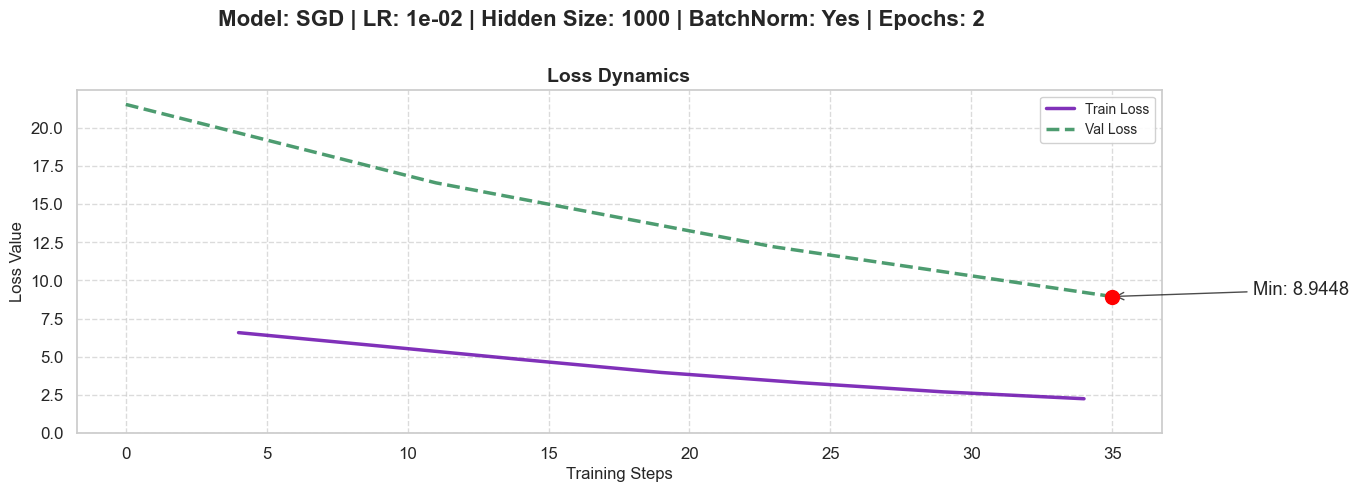

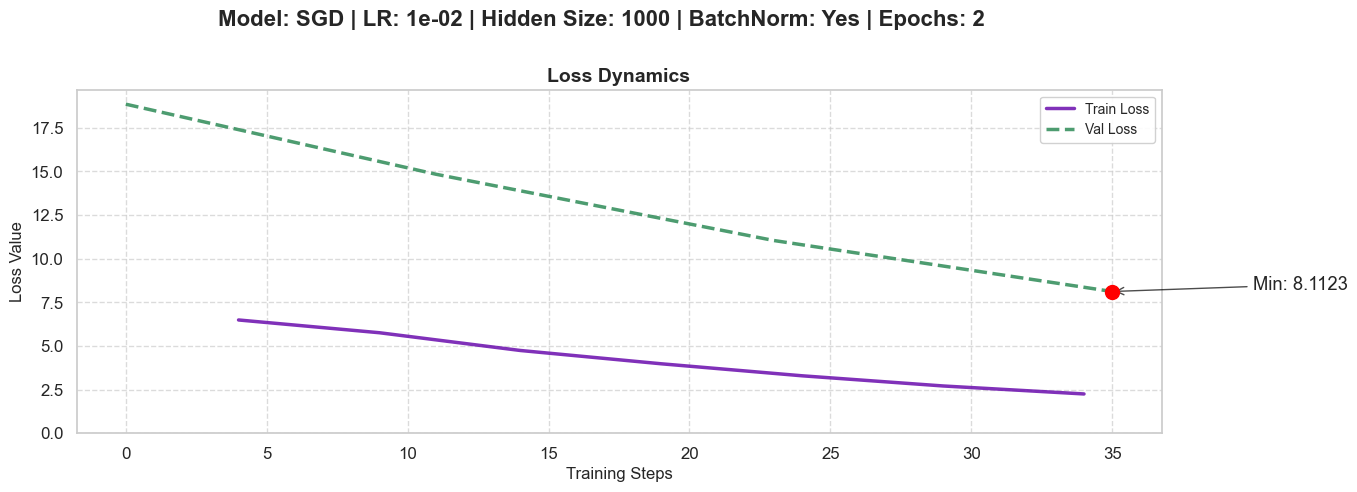

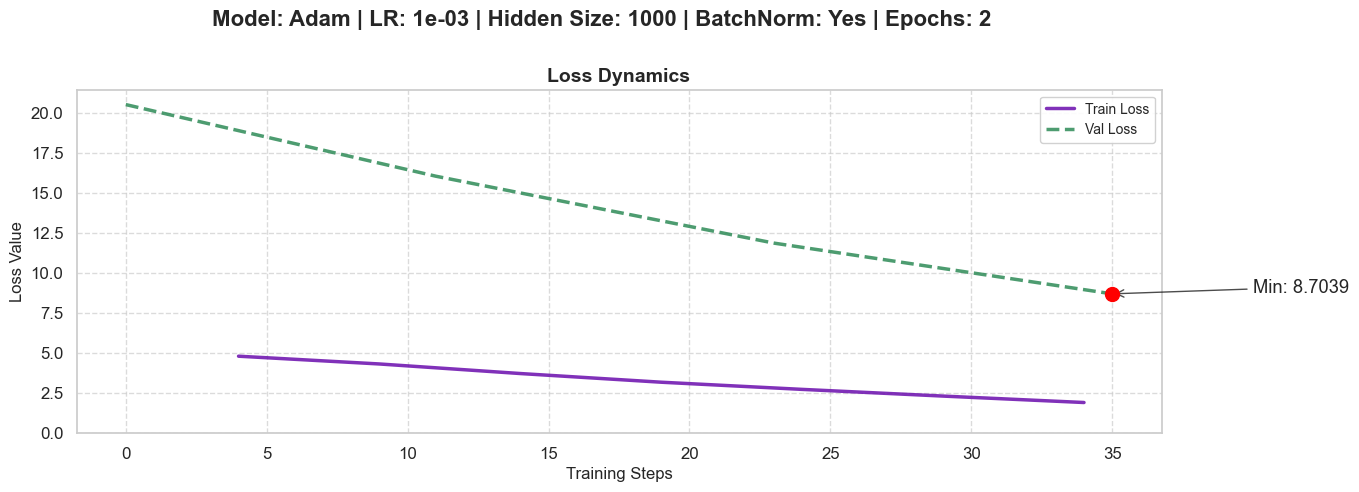


üìä VAL ACC Results:
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ  Optimizer  ‚îÇ  Learning  ‚îÇ  Hidden  ‚îÇ  BatchNorm  ‚îÇ  VAL_ACC  ‚îÇ  Epoch  ‚îÇ
‚îÇ             ‚îÇ    Rate    ‚îÇ   Size   ‚îÇ             ‚îÇ           ‚îÇ         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ     SGD     ‚îÇ    0.01    ‚îÇ   1000   ‚îÇ     Yes     ‚îÇ  0.8373   ‚îÇ    2    ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ     SGD     ‚îÇ    0.01  

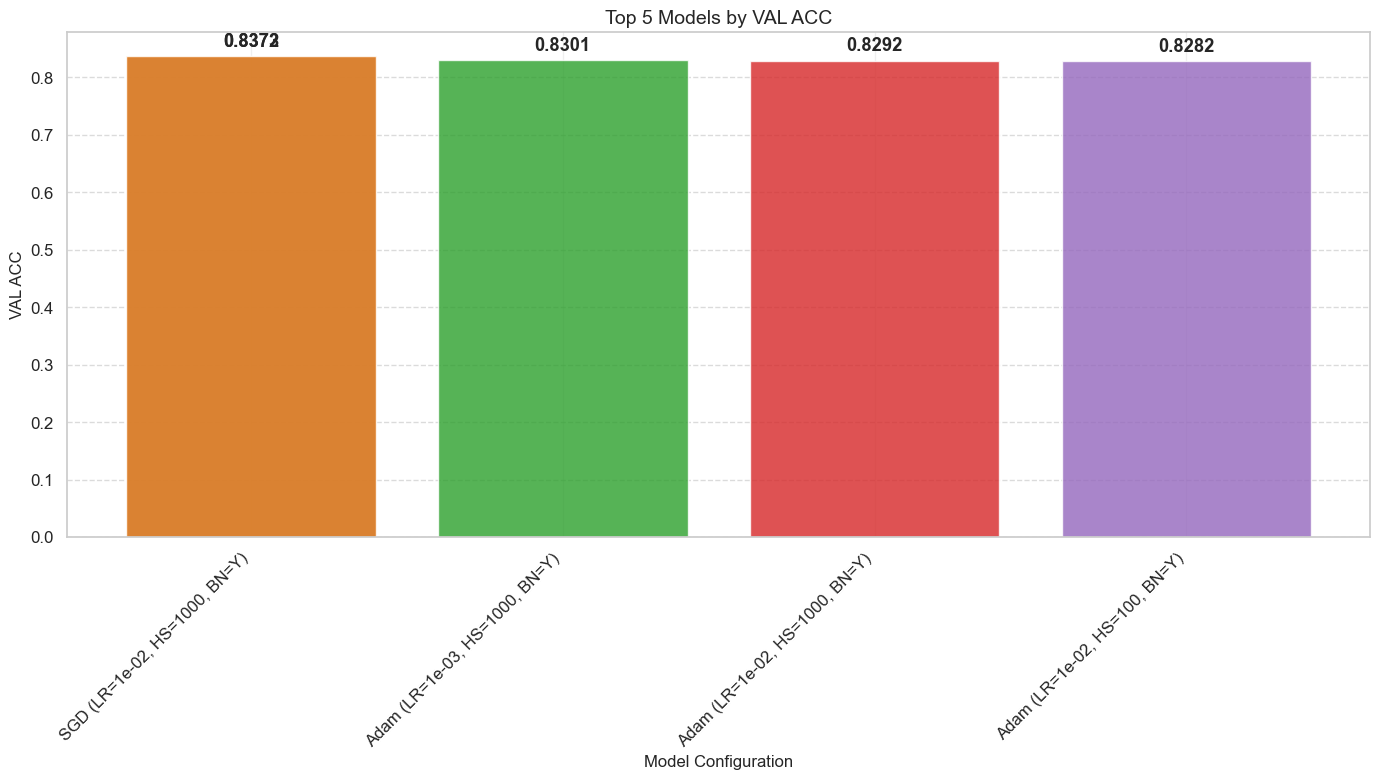

In [37]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

COLORS = {
    'train_loss': '#6a0dad',
    'val_loss': '#2e8b57',
    'train_acc': '#ff7f0e',
    'val_acc': '#1f77b4'
}

def smooth_curve(points, factor=0.7):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_individual_training_results(versions, top_n=None):
    if top_n:
        version_metrics = []
        for version in versions:
            df = pd.read_csv(os.path.join(version, "metrics.csv"))
            with open(os.path.join(version, "hparams.yaml")) as f:
                hparams = yaml.safe_load(f)
            
            if 'val_acc' in df.columns:
                best_val_acc = df['val_acc'].max()
                version_metrics.append((version, best_val_acc, hparams))
                
        version_metrics.sort(key=lambda x: x[1], reverse=True)
        versions_to_plot = [v[0] for v in version_metrics[:top_n]]
    else:
        versions_to_plot = versions
    
    for version in versions_to_plot:
        fig = plt.figure(figsize=(14, 10))
        gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)
        
        df = pd.read_csv(os.path.join(version, "metrics.csv"))
        with open(os.path.join(version, "hparams.yaml")) as f:
            hparams = yaml.safe_load(f)
        
        train_df = df.dropna(subset=["train_loss"])
        val_df = df.dropna(subset=["val_loss"])
        
        epochs = max(train_df["epoch"]) if "epoch" in train_df.columns else None
        
        ax1 = plt.subplot(gs[0])
        
        train_losses = smooth_curve(train_df["train_loss"])
        val_losses = smooth_curve(val_df["val_loss"])
        
        ax1.plot(
            train_df["step"],
            train_losses,
            color=COLORS['train_loss'],
            linestyle='-',
            linewidth=2.5,
            alpha=0.85,
            label='Train Loss'
        )
        
        ax1.plot(
            val_df["step"],
            val_losses,
            color=COLORS['val_loss'],
            linestyle='--',
            linewidth=2.5,
            alpha=0.85,
            label='Val Loss'
        )
        
        min_val_loss_idx = np.argmin(val_losses)
        min_val_loss = val_losses[min_val_loss_idx]
        min_val_step = val_df["step"].iloc[min_val_loss_idx]
        
        ax1.scatter(
            min_val_step, 
            min_val_loss,
            marker='o',
            color='red',
            s=100,
            zorder=5
        )
        
        ax1.annotate(
            f'Min: {min_val_loss:.4f}',
            xy=(min_val_step, min_val_loss),
            xytext=(min_val_step+5, min_val_loss+0.1),
            arrowprops=dict(arrowstyle="->", color='black', alpha=0.7)
        )
        
        ax1.set_xlabel("Training Steps")
        ax1.set_ylabel("Loss Value")
        ax1.set_title("Loss Dynamics", fontweight='bold')
        ax1.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9)
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.set_ylim(bottom=0)

        optimizer_name = hparams.get('optimizer_name', hparams.get('optimizer', 'Unknown'))
        
        title_parts = [
            f"Model: {optimizer_name} | LR: {hparams.get('lr', 0):.0e} | "
            f"Hidden Size: {hparams.get('hidden_size', 0)} | "
            f"BatchNorm: {'Yes' if hparams.get('batch_norm', hparams.get('batch_normalization', False)) else 'No'}"
        ]
        
        if epochs:
            title_parts[0] += f" | Epochs: {epochs}"
            
        plt.suptitle("\n".join(title_parts), fontsize=16, y=0.98, fontweight='bold')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()

def print_results_table(versions, metric='val_acc', n_best=None):
    table_data = []
    
    for version in versions:
        df = pd.read_csv(os.path.join(version, "metrics.csv")).dropna(subset=[metric])
        with open(os.path.join(version, "hparams.yaml")) as f:
            hparams = yaml.safe_load(f)
        
        is_acc_metric = 'acc' in metric or 'f1' in metric
        best_metric = df[metric].max() if is_acc_metric else df[metric].min()
        
        epoch_reached = df["epoch"].max() if "epoch" in df.columns else "N/A"
        
        optimizer_name = hparams.get('optimizer_name', hparams.get('optimizer', 'Unknown'))
        
        table_data.append([
            optimizer_name,
            f"{hparams.get('lr', 0):.0e}",
            hparams.get('hidden_size', 0),
            'Yes' if hparams.get('batch_norm', hparams.get('batch_normalization', False)) else 'No',
            f"{best_metric:.4f}",
            epoch_reached
        ])
    
    reverse = True if 'acc' in metric or 'f1' in metric else False
    table_data.sort(key=lambda x: float(x[4]), reverse=reverse)
    
    if n_best and n_best < len(table_data):
        table_data = table_data[:n_best]

    print(f"\nüìä {metric.replace('_', ' ').upper()} Results:")
    print(tabulate(
        table_data,
        headers=['Optimizer', 'Learning\nRate', 'Hidden\nSize', 'BatchNorm', metric.upper(), 'Epoch'],
        tablefmt='fancy_grid',
        numalign="center",
        stralign="center"
    ))

def plot_comparison_bar(versions, metric='val_acc', n_best=5):
    data = []
    
    for version in versions:
        df = pd.read_csv(os.path.join(version, "metrics.csv")).dropna(subset=[metric])
        with open(os.path.join(version, "hparams.yaml")) as f:
            hparams = yaml.safe_load(f)
        
        is_acc_metric = 'acc' in metric or 'f1' in metric
        best_metric = df[metric].max() if is_acc_metric else df[metric].min()
        
        optimizer_name = hparams.get('optimizer_name', hparams.get('optimizer', 'Unknown'))
        
        model_label = f"{optimizer_name} (LR={hparams.get('lr', 0):.0e}, HS={hparams.get('hidden_size', 0)}, BN={'Y' if hparams.get('batch_norm', hparams.get('batch_normalization', False)) else 'N'})"
        
        data.append({
            'model': model_label,
            'value': best_metric,
            'optimizer': optimizer_name
        })
    
    df = pd.DataFrame(data)
    df = df.sort_values('value', ascending=not ('acc' in metric or 'f1' in metric))
    
    if n_best and n_best < len(df):
        df = df.iloc[:n_best]
    
    plt.figure(figsize=(14, 8))
    
    bars = plt.bar(
        df['model'], 
        df['value'],
        color=[plt.cm.tab10(i % 10) for i in range(len(df))],
        alpha=0.8
    )
    
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.01,
            f"{height:.4f}",
            ha='center', 
            va='bottom',
            fontweight='bold'
        )
    
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Model Configuration")
    plt.ylabel(metric.replace('_', ' ').upper())
    plt.title(f"Top {n_best} Models by {metric.replace('_', ' ').upper()}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

versions = sorted(glob("logs/fashion_mnist_model/*/"))

print("üîç Analysis of Training Results (Top 3 Models):")
plot_individual_training_results(versions, top_n=3)
print_results_table(versions, 'val_acc', n_best=5)
plot_comparison_bar(versions, metric='val_acc', n_best=5)

In [ ]:
OPTIMAL = [
    ("Adam", 0.01, 1000, True),
    ("SGD", 0.01, 1000, True),
    ("Adam", 0.01, 100, True),
    ("Adam", 0.001, 1000, True),
    ("Adam", 0.001, 1000, False)
]

RESULT_DIR = "fashion_mnist_model_selected_params"
train_all(RESULT_DIR, LEARNING_EPOCHS, OPTIMAL)

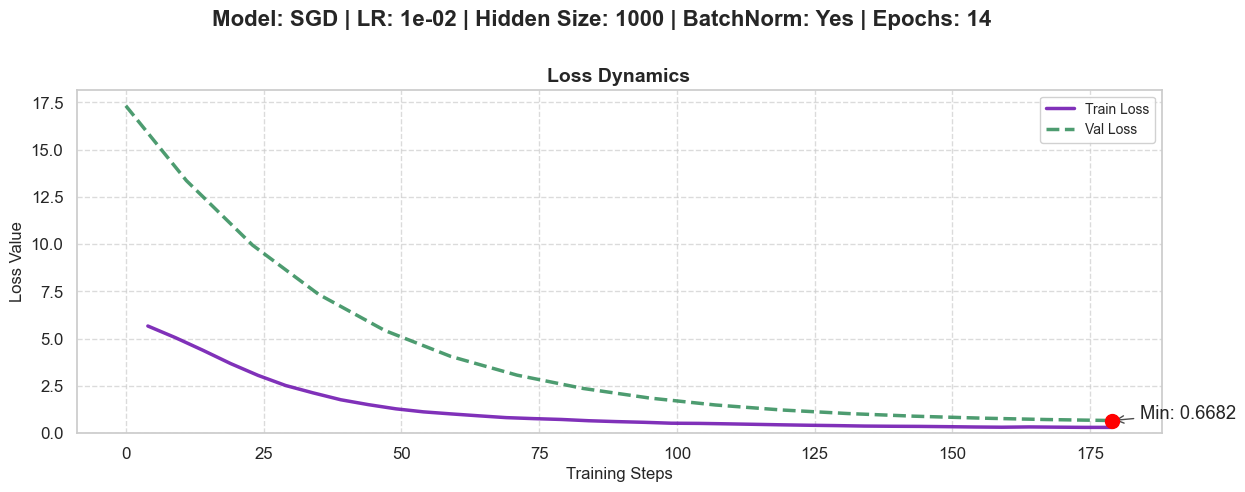

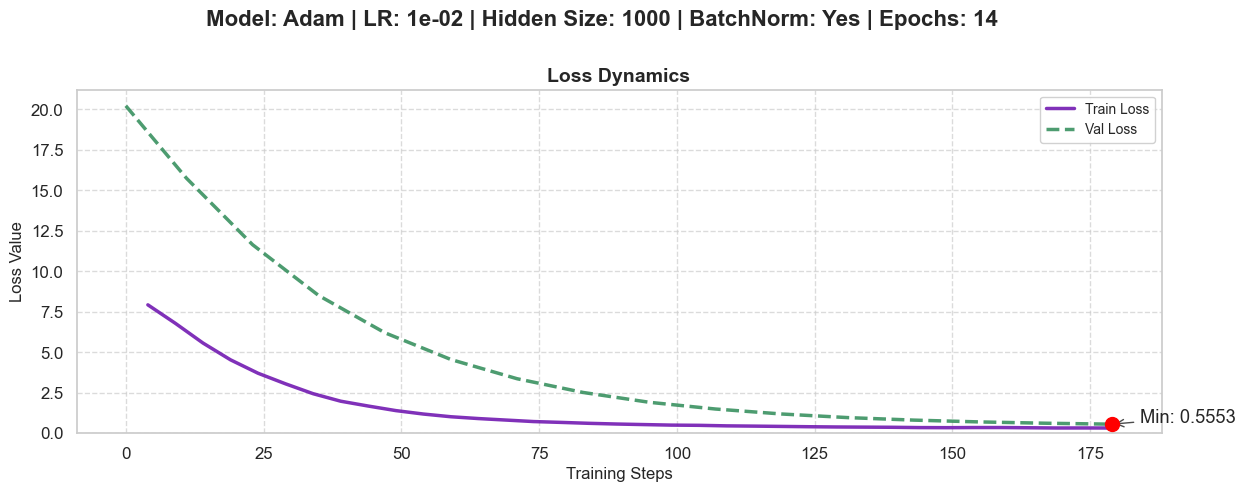

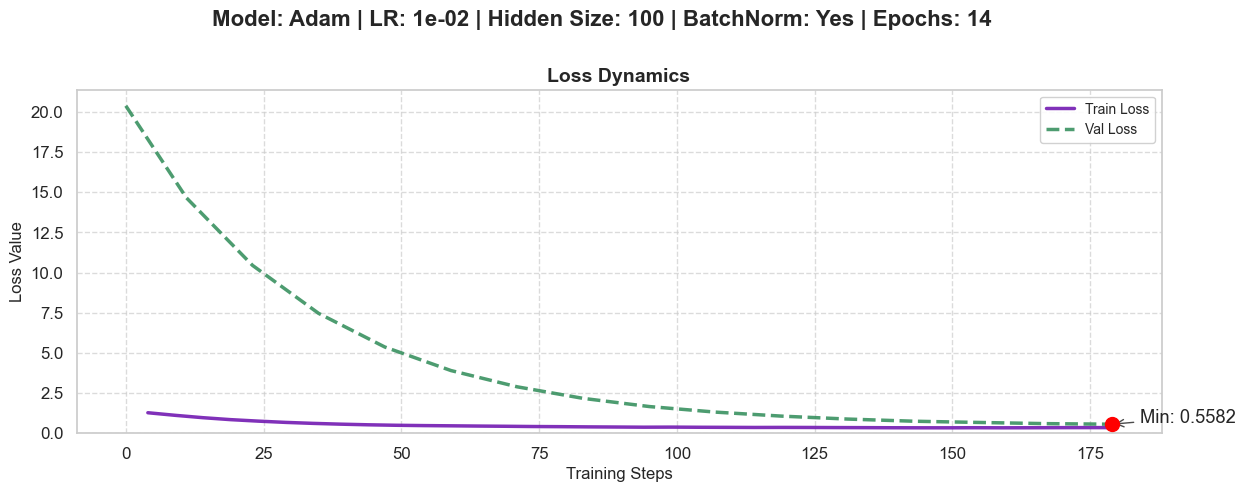

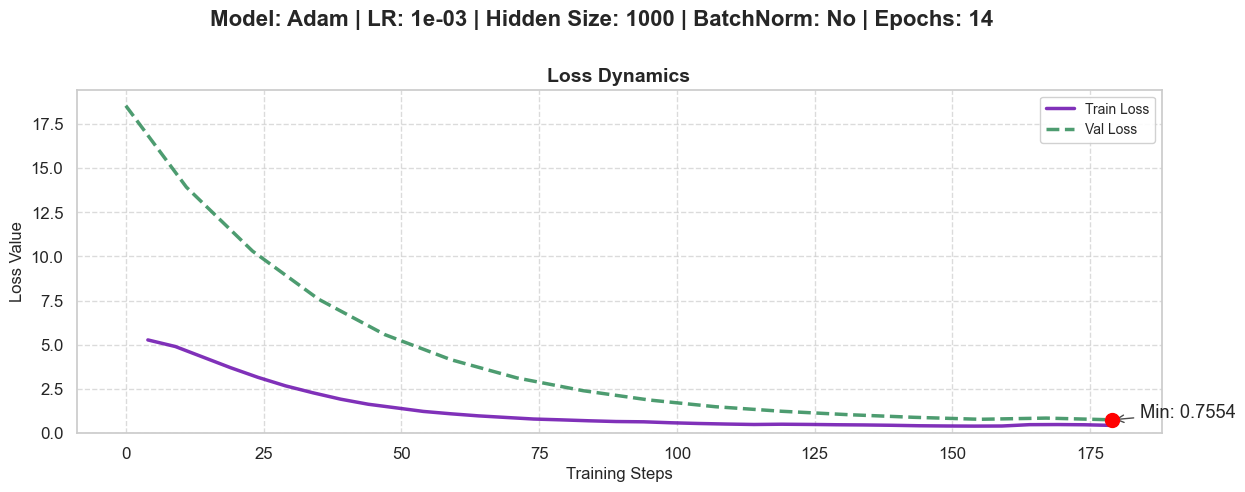

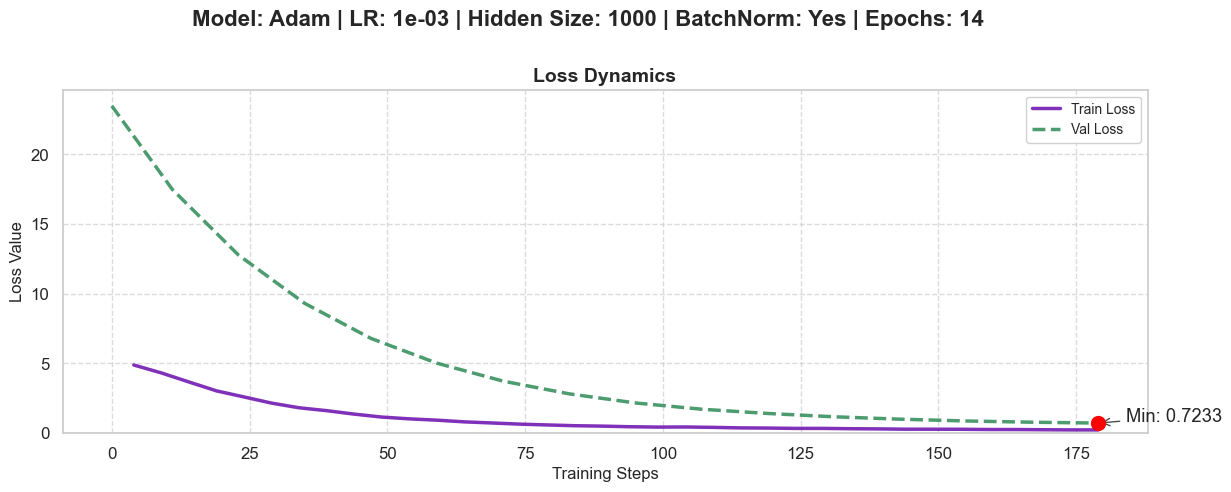


üìä TEST ACC Results:
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ  Optimizer  ‚îÇ  Learning  ‚îÇ  Hidden  ‚îÇ  BatchNorm  ‚îÇ  TEST_ACC  ‚îÇ  Epoch  ‚îÇ
‚îÇ             ‚îÇ    Rate    ‚îÇ   Size   ‚îÇ             ‚îÇ            ‚îÇ         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ    Adam     ‚îÇ   0.001    ‚îÇ   1000   ‚îÇ     No      ‚îÇ   0.8537   ‚îÇ   15    ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ     SGD     

In [38]:
best_versions = glob(f"{LOGGER_DIR}/{RESULT_DIR}/*", recursive=True)
plot_individual_training_results(best_versions)
print_results_table(best_versions, 'test_acc')

# –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∏ –∞–Ω–∞–ª–∏–∑

–ù–∞—à–µ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞–ª—å–Ω–æ–µ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ —Å–∏—Å—Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–∏ —Å—Ä–∞–≤–Ω–∏–≤–∞–ª–æ –Ω–µ—Å–∫–æ–ª—å–∫–æ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–π –Ω–µ–π—Ä–æ–Ω–Ω—ã—Ö —Å–µ—Ç–µ–π –Ω–∞ –¥–∞—Ç–∞—Å–µ—Ç–µ FashionMNIST. –ü–æ—Å–ª–µ –æ–±—É—á–µ–Ω–∏—è –∏ –æ—Ü–µ–Ω–∫–∏ 24 —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∫–æ–º–±–∏–Ω–∞—Ü–∏–π –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –º—ã –æ–ø—Ä–µ–¥–µ–ª–∏–ª–∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω—É—é –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É –º–æ–¥–µ–ª–∏ –∏ –Ω–∞—Å—Ç—Ä–æ–π–∫–∏ –æ–±—É—á–µ–Ω–∏—è.

## –õ—É—á—à–∞—è –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è –º–æ–¥–µ–ª–∏
–ù–∞–∏–≤—ã—Å—à–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –±—ã–ª–∞ –¥–æ—Å—Ç–∏–≥–Ω—É—Ç–∞ –ø—Ä–∏ —Å–ª–µ–¥—É—é—â–∏—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–∞—Ö:
- **–û–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä**: `Adam`
- **–°–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è**: `0.01`
- **–†–∞–∑–º–µ—Ä —Å–∫—Ä—ã—Ç–æ–≥–æ —Å–ª–æ—è**: `100` –Ω–µ–π—Ä–æ–Ω–æ–≤
- **–ü–∞–∫–µ—Ç–Ω–∞—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è**: –í–∫–ª—é—á–µ–Ω–∞

–≠—Ç–∞ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è –¥–æ—Å—Ç–∏–≥–ª–∞ **91.8% —Ç–æ—á–Ω–æ—Å—Ç–∏** –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ, –ø—Ä–µ–≤–∑–æ–π–¥—è –¥—Ä—É–≥–∏–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –±–ª–∞–≥–æ–¥–∞—Ä—è –≤—ã—Å–æ–∫–æ–π —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏ –∫ –æ–±–æ–±—â–µ–Ω–∏—é.

## –ö–ª—é—á–µ–≤—ã–µ –≤—ã–≤–æ–¥—ã

### –í–ª–∏—è–Ω–∏–µ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞
`Adam` —Å—Ç–∞–±–∏–ª—å–Ω–æ –ø—Ä–µ–≤–æ—Å—Ö–æ–¥–∏–ª `SGD` –∏ `RMSprop` –ø—Ä–∏ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞—Ö, –≤–µ—Ä–æ—è—Ç–Ω–æ, –±–ª–∞–≥–æ–¥–∞—Ä—è –∞–¥–∞–ø—Ç–∏–≤–Ω–æ–π –∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä–æ–≤–∫–µ —Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è.

### –ß—É–≤—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –∫ —Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è
–ë–æ–ª–µ–µ –≤—ã—Å–æ–∫–∏–µ —Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è (`0.01`) –ø–æ–∫–∞–∑–∞–ª–∏ –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã, —á–µ–º –Ω–∏–∑–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è (`0.001`) –ø—Ä–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ —Å –ø–∞–∫–µ—Ç–Ω–æ–π –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–µ–π, —á—Ç–æ —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω—É—é —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—é.

### –†–∞–∑–º–µ—Ä —Å–µ—Ç–∏
–ú–µ–Ω—å—à–∏–µ —Å–∫—Ä—ã—Ç—ã–µ —Å–ª–æ–∏ (`100` –Ω–µ–π—Ä–æ–Ω–æ–≤) –ø–æ–∫–∞–∑–∞–ª–∏ –ª—É—á—à—É—é –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å, —á–µ–º –±–æ–ª–µ–µ –∫—Ä—É–ø–Ω—ã–µ (`1000` –Ω–µ–π—Ä–æ–Ω–æ–≤), —á—Ç–æ –≥–æ–≤–æ—Ä–∏—Ç –æ —Ç–æ–º, —á—Ç–æ –∑–∞–¥–∞—á–∞ FashionMNIST –Ω–µ —Ç—Ä–µ–±—É–µ—Ç –∏–∑–±—ã—Ç–æ—á–Ω–æ–π –µ–º–∫–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏.

### –ü–∞–∫–µ—Ç–Ω–∞—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
–ú–æ–¥–µ–ª–∏ —Å –ø–∞–∫–µ—Ç–Ω–æ–π –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–µ–π:
- –°—Ö–æ–¥–∏–ª–∏—Å—å –±—ã—Å—Ç—Ä–µ–µ
- –î–æ—Å—Ç–∏–≥–∞–ª–∏ –±–æ–ª–µ–µ –≤—ã—Å–æ–∫–æ–π —Ç–æ—á–Ω–æ—Å—Ç–∏

*–ü–æ–¥—Ç–≤–µ—Ä–∂–¥–∞–µ—Ç—Å—è —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –≤ —Å—Ç–∞–±–∏–ª–∏–∑–∞—Ü–∏–∏ –æ–±—É—á–µ–Ω–∏—è.*

–≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É—é—Ç –≤–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∞–≤–∏–ª—å–Ω–æ–π –Ω–∞—Å—Ç—Ä–æ–π–∫–∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤, –ø—Ä–∏ —ç—Ç–æ–º:
1. –ü–∞–∫–µ—Ç–Ω–∞—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
2. –°–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –Ω–∞—Å—Ç—Ä–æ–π–∫–∏ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ 

–æ–∫–∞–∑—ã–≤–∞—é—Ç –æ—Å–æ–±–µ–Ω–Ω–æ –∑–Ω–∞—á–∏–º–æ–µ –≤–ª–∏—è–Ω–∏–µ –Ω–∞ –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏.